# Improved georeferencing through higher quality pose information

In this notebook we show how the final projected and georeferenced mosaic from our `georeference()` function can be improved with a higher quality input yaw and pitch. We do this by utiziling high accuracy data from a UAS gimbal that records higher accuracy pose information.

Our process is simple, first we grab the processed Rrs imagery and metadata, then we pull in the .csv of higher accuracy yaw and pitch, and use this to do the georeferencing.

Pull in all the modules needed for this code.

In [1]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import multiprocessing
import glob, shutil, os

import cv2
import numpy as np
import matplotlib.pyplot as plt


import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import exiftool
import datetime

import subprocess
import math

from utils import *
# from georeg import *

import random
import cameratransform as ct
from rasterio.merge import merge

In [2]:
# this isn't really good practice but there are a few deprecated tools in the Micasense stack so we'll ignore some of these warnings
import warnings
warnings.filterwarnings('ignore')

We'll use a dataset that is already processed, simply the output of the `process_raw_to_rrs()` function with the addition of a .csv file output from the gimbal.

In [7]:
#project_path = os.path.join('sample_datasets','estuarine_dataset/')
project_path = os.path.join('sample_datasets','open_ocean_dataset/')
project_path

'sample_datasets/open_ocean_dataset/'

Pull in the imagery and metadata

In [8]:
rrs_imgs, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_mobley', count=5)

FileNotFoundError: [Errno 2] No such file or directory: 'sample_datasets/open_ocean_dataset/metadata.csv'

## View metadata 

Metadata is the same for each processed dataset

In [5]:
img_metadata.head()

,SourceFile,GPSDateStamp,GPSTimeStamp,GPSLatitude,GPSLatitudeRef,GPSLongitude,GPSLongitudeRef,GPSAltitude,FocalLength,ImageWidth,ImageHeight,GPSImgDirection,GPSPitch,GPSRoll,UTC-Time
filename,,,,,,,,,,,,,,,
capture_1.tif,sample_datasets/estuarine_dataset/capture_1.tif,2021:04:07,13:26:31,34.715206,N,-76.673312,W,22.412,7.783703,2064,1544,-95.612125,-4.809893,4.833103,2021-04-07 13:26:31
capture_2.tif,sample_datasets/estuarine_dataset/capture_2.tif,2021:04:07,13:31:08,34.714973,N,-76.675288,W,34.022,7.783703,2064,1544,-98.253559,-0.269329,9.414915,2021-04-07 13:31:08
capture_3.tif,sample_datasets/estuarine_dataset/capture_3.tif,2021:04:07,13:31:11,34.714974,N,-76.675289,W,34.064,7.783703,2064,1544,-97.252677,0.166681,9.188154,2021-04-07 13:31:11
capture_4.tif,sample_datasets/estuarine_dataset/capture_4.tif,2021:04:07,13:31:13,34.714975,N,-76.675291,W,33.897,7.783703,2064,1544,-96.242855,0.317755,9.093116,2021-04-07 13:31:13
capture_5.tif,sample_datasets/estuarine_dataset/capture_5.tif,2021:04:07,13:31:16,34.714975,N,-76.675295,W,33.118,7.783703,2064,1544,-95.169319,0.503772,9.040661,2021-04-07 13:31:16


### Georeferencing 


Let's see the standard georeferencing first based on the sensor data. Note this sensor was mounted to be 25 degrees off nadir and then the DLS (where the yaw pitch and roll is measured) was directly on the top of the drone so we need to add in this offset.

In [6]:
pitch_offset = 25

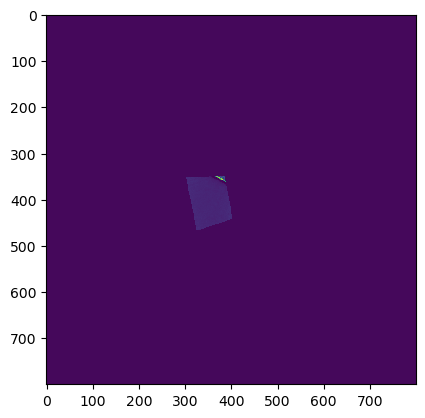

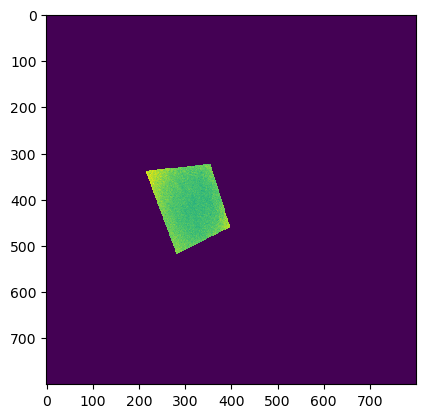

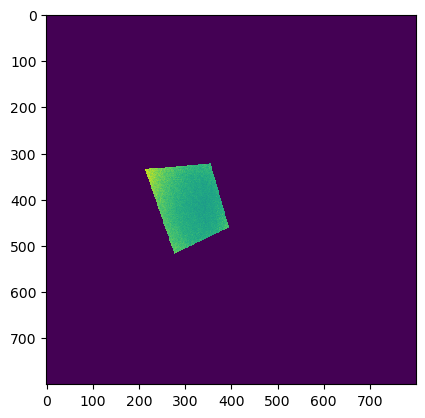

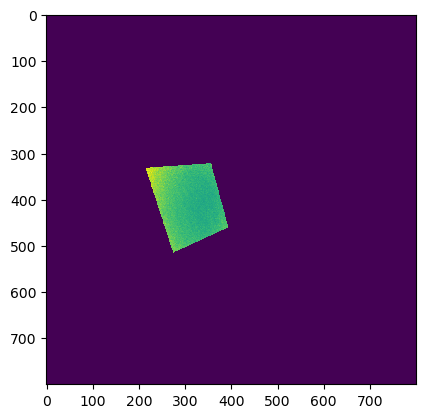

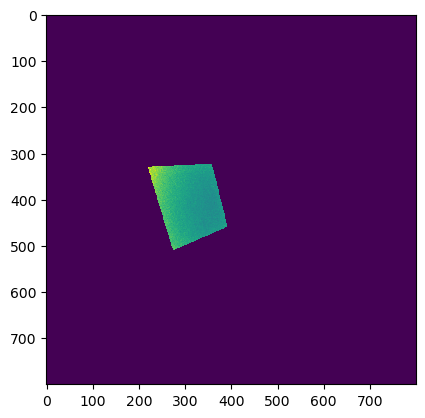

True

In [7]:
georeference(project_path, project_path+'rrs_mobley', project_path+'georeferenced_rrs_mobley', rrs_imgs, 
             img_metadata, pitch_offset=pitch_offset, plot=True)

Now we want to read in the logs from the gimbal which will show a much more accurate yaw in particular. This is just a custom parser made for the output of this gimbal logger.

In [8]:
def format_alta_logs(fp):
    alta_logs = pd.read_csv(fp)
    # the last few hundred lines don't follow csv rules and are just summary data
    alta_logs.drop(alta_logs.tail(250).index,inplace=True)
    # this may introduce a tiny bit of error but I do this so I have a unique index for matching time
    # TODO could instead resample to seconds and take a mean
    alta_logs['id'] = alta_logs.index
    alta_logs['dt'] = pd.to_datetime(alta_logs.Date.apply(str)+alta_logs['GPS Time']+'.'+alta_logs.id.apply(str).str.zfill(9).apply(str).str.slice(start=3,stop=9), format='%Y%m%d%H:%M:%S.%f')
    alta_logs = alta_logs.set_index('dt')
    alta_logs = alta_logs.sort_index()
    return(alta_logs)

In [9]:
alta_logs = format_alta_logs(project_path + '/SYNLog-13-24-55_07-04-2021.csv')
alta_logs.head()

,Reading,IMU Time,Date,GPS Time,Unnamed: 4,Longitude,Latitude,GPS Height,GPS Course,GPS Pos N,...,Gyro Bias P,Gyro Bias Y,Accel Bias X,Accel Bias Y,Accel Bias Z,Extended Status,5V Alarm,Z Vibration,Checksum,id
dt,,,,,,,,,,,,,,,,,,,,,
2021-04-07 13:24:55.000000,41,1.6,20210407,13:24:55,NaN,-766726976,347156896,1.27,18.5,-6.43,...,-39.3661,6.5308,-0.004,0.001,0.272,0.0,0.0,0.04,239.0,0
2021-04-07 13:24:55.000001,42,1.64,20210407,13:24:55,NaN,-766726976,347156896,1.27,18.5,-6.43,...,-39.3580,6.5309,-0.004,0.001,0.272,0.0,0.0,0.03,110.0,1
2021-04-07 13:24:55.000002,43,1.68,20210407,13:24:55,NaN,-766726976,347156896,1.27,18.5,-6.43,...,-39.3630,6.5349,-0.004,0.001,0.272,0.0,0.0,0.03,138.0,2
2021-04-07 13:24:55.000003,44,1.72,20210407,13:24:55,NaN,-766726976,347156896,1.27,18.5,-6.43,...,-39.3628,6.5372,-0.004,0.000,0.273,0.0,0.0,0.03,50.0,3
2021-04-07 13:24:55.000004,45,1.76,20210407,13:24:55,NaN,-766726976,347156896,1.27,18.5,-6.43,...,-39.3647,6.5371,-0.005,0.000,0.273,0.0,0.0,0.03,234.0,4


Now let's go through and grab the yaws from each entry that corresponds to an image and add that into our metadata

In [10]:
alta_yaws = []
for index, row in img_metadata.iterrows(): # yes I know this is an anti-pattern
    # utc_time = datetime.datetime.strptime(row['UTC-Time'], '%Y-%m-%d-%H:%M:%S')
    img_idx = alta_logs.index.get_loc(row['UTC-Time'], method='nearest')
    alta_yaws.append((alta_logs.iloc[img_idx]['Yaw'] + 360) % 360)
    
img_metadata['alta_yaw'] = alta_yaws

In [12]:
img_metadata.head()

,SourceFile,GPSDateStamp,GPSTimeStamp,GPSLatitude,GPSLatitudeRef,GPSLongitude,GPSLongitudeRef,GPSAltitude,FocalLength,ImageWidth,ImageHeight,GPSImgDirection,GPSPitch,GPSRoll,UTC-Time,alta_yaw
filename,,,,,,,,,,,,,,,,
capture_1.tif,sample_datasets/estuarine_dataset/capture_1.tif,2021:04:07,13:26:31,34.715206,N,-76.673312,W,22.412,7.783703,2064,1544,-95.612125,-4.809893,4.833103,2021-04-07 13:26:31,254.7
capture_2.tif,sample_datasets/estuarine_dataset/capture_2.tif,2021:04:07,13:31:08,34.714973,N,-76.675288,W,34.022,7.783703,2064,1544,-98.253559,-0.269329,9.414915,2021-04-07 13:31:08,245.1
capture_3.tif,sample_datasets/estuarine_dataset/capture_3.tif,2021:04:07,13:31:11,34.714974,N,-76.675289,W,34.064,7.783703,2064,1544,-97.252677,0.166681,9.188154,2021-04-07 13:31:11,245.0
capture_4.tif,sample_datasets/estuarine_dataset/capture_4.tif,2021:04:07,13:31:13,34.714975,N,-76.675291,W,33.897,7.783703,2064,1544,-96.242855,0.317755,9.093116,2021-04-07 13:31:13,245.0
capture_5.tif,sample_datasets/estuarine_dataset/capture_5.tif,2021:04:07,13:31:16,34.714975,N,-76.675295,W,33.118,7.783703,2064,1544,-95.169319,0.503772,9.040661,2021-04-07 13:31:16,245.0


Now let's change the yaw_name parameter to the new improved yaw.

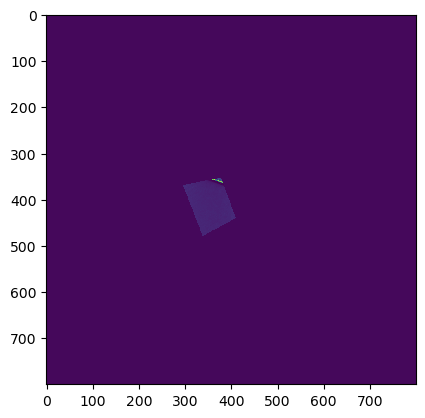

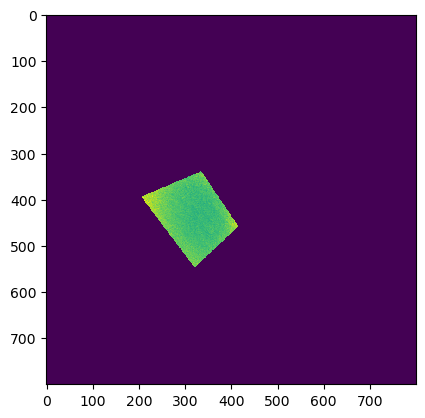

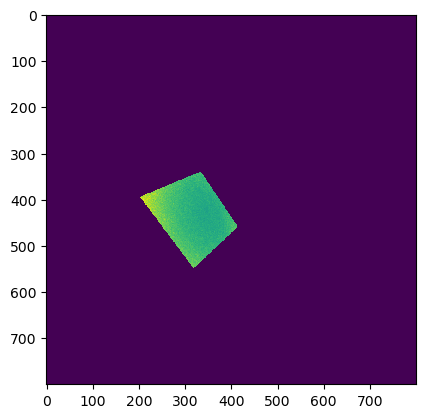

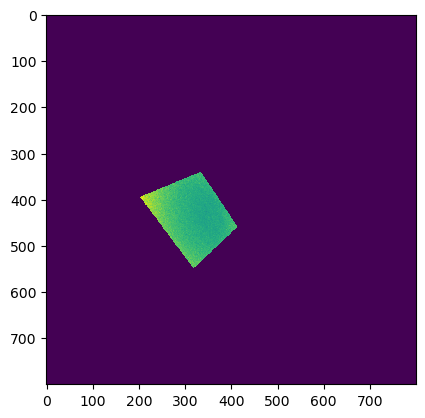

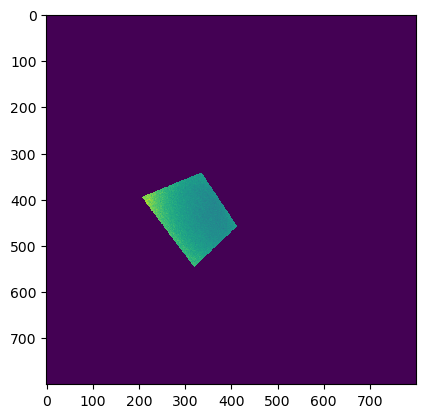

True

In [13]:
georeference(project_path, project_path+'rrs_mobley', project_path+'georeferenced_rrs_mobley_improved', rrs_imgs, 
             img_metadata, yaw_name='alta_yaw', pitch_offset=pitch_offset, plot=True)

Now let's compare with and without the improved yaw

In [14]:
standard_imgs, standard_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/georeferenced_rrs_mobley', count=1)
improved_imgs, improved_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/georeferenced_rrs_mobley_improved', count=1)

(300.0, 500.0)

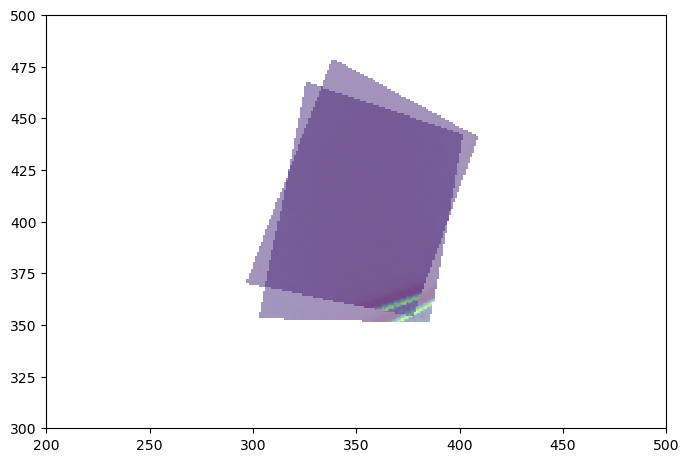

In [15]:
fig, ax = plt.subplots(figsize=(8,8))

standard_imgs[standard_imgs == 0] = np.nan
improved_imgs[improved_imgs == 0] = np.nan

ax.imshow(standard_imgs[0,1],alpha=0.5)
ax.imshow(improved_imgs[0,1],alpha=0.5)

ax.set_xlim(200,500)
ax.set_ylim(300,500)

### Not a huge difference but potentially important!

We can also mosaic these images using a wrapper around the rasterio.mosaic function.

In [30]:
?mosaic

(5, 930, 1707)


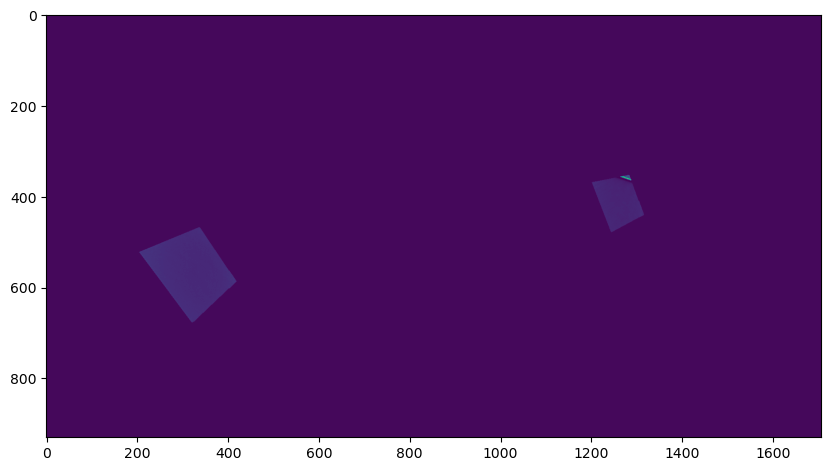

In [5]:
foo = mosaic(main_dir=project_path, img_dir = project_path+'/georeferenced_rrs_mobley_improved', output_name='mosaic_improved', plot=True, save=True, band_to_plot=0)
print(foo.shape)

In [6]:
foo[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

And these images can be added to a GIS tool like QGIS or incorporated into a variety of processing pipelines!